In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from scipy.stats import normaltest, boxcox
from statsmodels.stats import diagnostic

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales']
X = data[['TV','Radio','Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [ 0.04576465  0.18853002 -0.00103749]

Intercept: 
 2.93888936946

R-squared:
0.897210638179


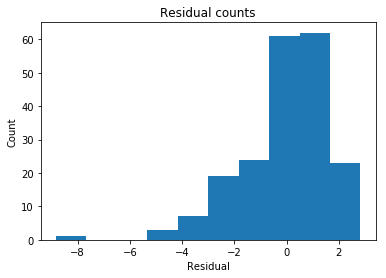

In [3]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = Y

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [4]:
rn1 = normaltest(residual)[1] #residual normaltest 1 p_val
rn1

7.608085583221961e-14

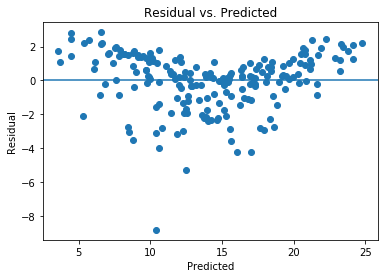

In [5]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.

In [6]:
# test hederoscedasticity
rh1 = diagnostic.het_breuschpagan(residual, predicted.reshape(len(predicted),1))[3] #residual heterscedasticity test 1 p_val
rh1

5.545608812093942e-07

In [7]:
correlation_matrix = X.corr()
display(correlation_matrix)

,TV,Radio,Newspaper
TV,1.000,0.055,0.057
Radio,0.055,1.000,0.354
Newspaper,0.057,0.354,1.000


## Drill: fixing assumptions
Judging from the diagnostic plots, your data has a problem with both heteroscedasticity and multivariate non-normality. Use the cell(s) below to see what you can do to fix it.

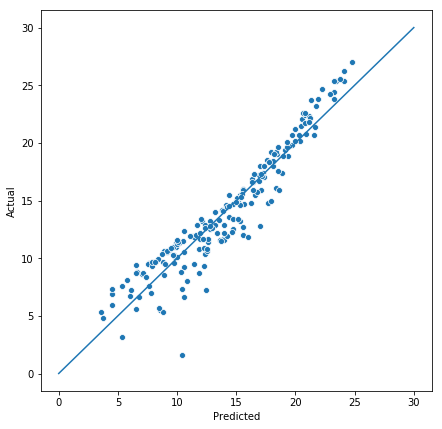

In [8]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=predicted, y=actual)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.plot([0,30],[0,30])

NormaltestResult(statistic=7.3436189333463089, pvalue=0.025430412805360583)

after box cox transformation:
 NormaltestResult(statistic=0.24434684761275421, pvalue=0.88499487601336346)


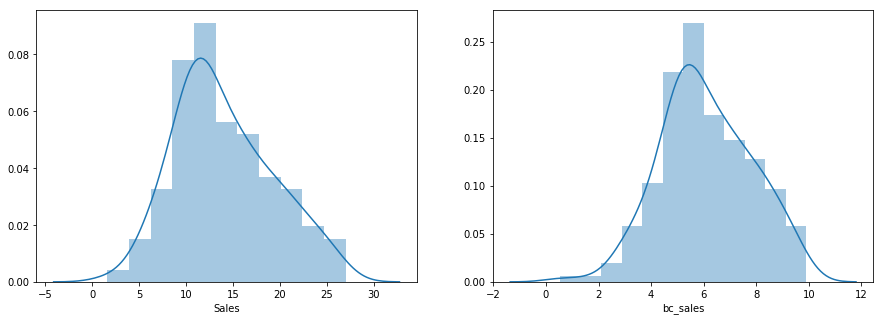

In [9]:
print(normaltest(data['Sales'])) # test normality of dependent variable

data['bc_sales'] = boxcox(data['Sales'])[0] # box cox transformation of dependent variable

print('\nafter box cox transformation:\n', normaltest(data['bc_sales'])) # retest normality on transformed dependent variable

fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.distplot(data['Sales'], ax=axes[0])
sns.distplot(data['bc_sales'], ax=axes[1])


The dependent variable (Sales) has been transformed using box cox. It is now much more normal. Hopefully this will help  heteroscedasticity and/or multivariate non-normality

In [10]:
# REDO: Instantiate and fit our model with boxcox transformed sales

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['bc_sales']
X = data[['TV','Radio']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = Y

# Calculate the error, also called the residual.
residual = actual - predicted

print('\nresidual normal test before (pval): ', rn1, '\nresidual normal test now (pval): ', normaltest(residual)[1])
print('\nresidual homoscedasticity test before (pval): ', rh1, '\nresidual homoscedasticity test now (pval): ', diagnostic.het_breuschpagan(residual, predicted.reshape(len(predicted),1))[3])



Coefficients: 
 [ 0.01547779  0.05856743]

Intercept: 
 2.45176372663

R-squared:
0.882784205931

residual normal test before (pval):  7.60808558322e-14 
residual normal test now (pval):  7.71761221204e-31

residual homoscedasticity test before (pval):  5.54560881209e-07 
residual homoscedasticity test now (pval):  0.00211794774089


multivariate normality was not improved. homscedasticity was slightly improved. More needs to be done

In [11]:
def std_dev_lines(dist, num_stdevs, color='red'):
    for i in range(1,num_stdevs+1):
        plt.axvline(np.mean(dist), color=color, linestyle='solid', linewidth=2)
        plt.axvline(np.mean(dist) + i*np.std(dist), color=color, linestyle='dashed', linewidth=2)
        plt.axvline(np.mean(dist) - i*np.std(dist), color=color, linestyle='dashed', linewidth=2)
    print('Mean: {} \nStandard Deviation: {}'.format(np.mean(dist), np.std(dist)))

Mean: 4.1300296516055825e-16 
Standard Deviation: 0.5915372808334771


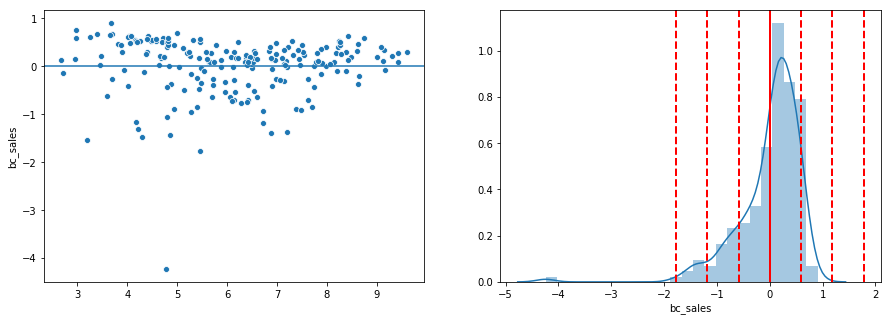

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.scatterplot(predicted, residual, ax=axes[0])
axes[0].axhline(y=0)
     
sns.distplot(residual, ax=axes[1])
std_dev_lines(residual, 3)

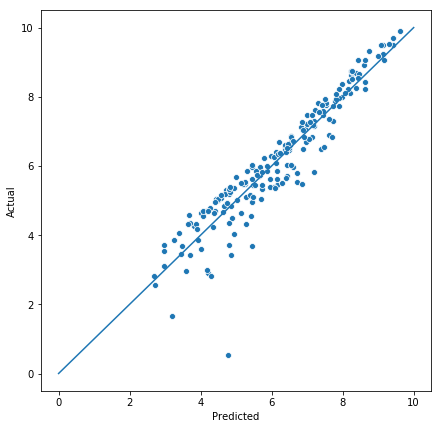

In [13]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=predicted, y=actual)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.plot([0,10],[0,10])

In [14]:
# drop biggest outlier and re-boxcox
data = data.drop(130)
data['bc_sales'] = boxcox(data['Sales'])[0] # box cox transformation of dependent variable

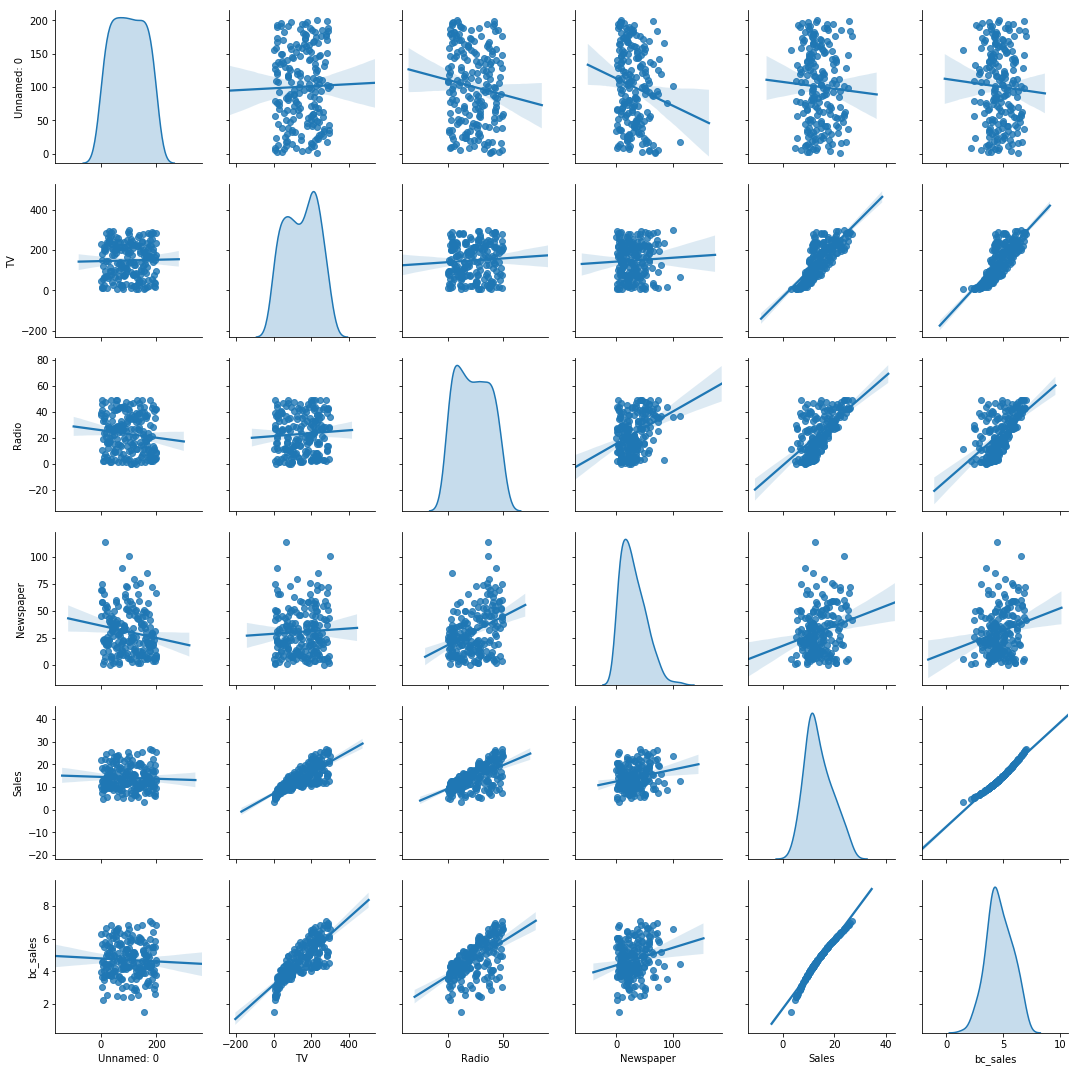

In [15]:
sns.pairplot(data=data, diag_kind='kde', kind='reg')
plt.show()

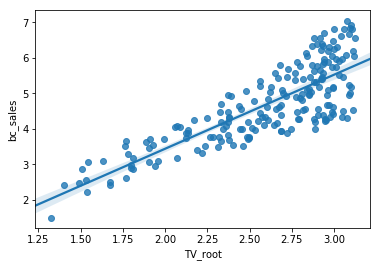

In [16]:
# transform TV variable to be more linear
data['TV_root'] = data['TV']**.2
sns.regplot(data=data, x='TV_root', y='bc_sales')

In [17]:
# REDO: Instantiate and fit our model with boxcox transformed sales

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['bc_sales']
X = data[['TV_root','Radio', 'Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = Y

# Calculate the error, also called the residual.
residual = actual - predicted

print('\nresidual normal test before (pval): ', rn1, '\nresidual normal test now (pval): ', normaltest(residual)[1])
print('\nresidual homoscedasticity test before (pval): ', rh1, '\nresidual homoscedasticity test now (pval): ', diagnostic.het_breuschpagan(residual, predicted.reshape(len(predicted),1))[3])



Coefficients: 
 [  2.04750518e+00   4.09209248e-02  -3.37707184e-04]

Intercept: 
 -1.56994491928

R-squared:
0.965131346347

residual normal test before (pval):  7.60808558322e-14 
residual normal test now (pval):  0.665044825675

residual homoscedasticity test before (pval):  5.54560881209e-07 
residual homoscedasticity test now (pval):  4.28029676603e-14


R squared was improved. multivariate normality was improved, but homoscedasticity was made worse. Residual plot below shows a bit of a "U" shape.

Mean: 6.471651801835083e-17 
Standard Deviation: 0.2065292627748486


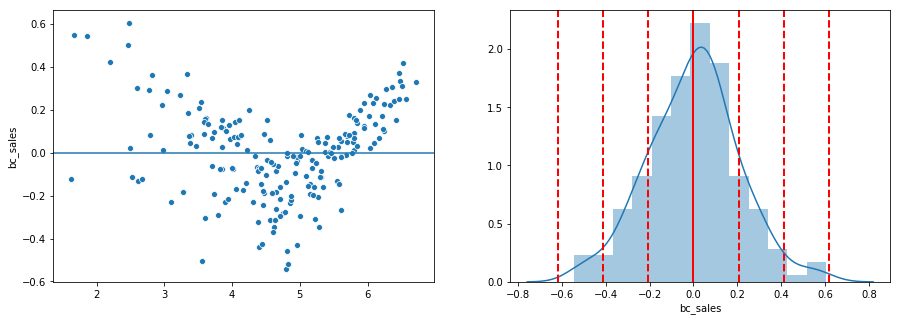

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.scatterplot(predicted, residual, ax=axes[0])
axes[0].axhline(y=0)
     
sns.distplot(residual, ax=axes[1])
std_dev_lines(residual, 3)

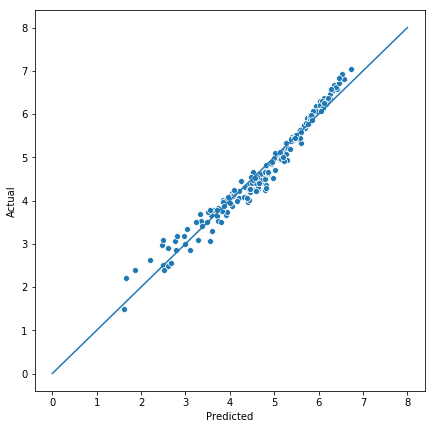

In [19]:
plt.figure(figsize=(7,7))
x=.2
sns.scatterplot(x=predicted, y=actual)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.plot([0,8],[0,8])